In [ ]:
from google.colab import drive

# 1. Google Drive 마운트
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 2. 파일 경로 설정 (사용자 지정 경로)
data_root = '/content/drive/MyDrive/Colab Notebooks/datathon/주력_비주력상품 데이터/주력상품'
# file_path = f'{data_root}/2019-Nov.csv'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import os

In [ ]:
sns.set()

# 그래프 기본 설정
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False
import matplotlib as mpl
import matplotlib.font_manager as fm

# 폰트 파일 경로 지정
font_path = '/content/drive/MyDrive/font/NanumGothic.ttf'

# 폰트 등록 및 matplotlib 설정
font_name = fm.FontProperties(fname=font_path).get_name()
fm.fontManager.addfont(font_path)
mpl.rc('font', family=font_name)

In [ ]:
# 데이터 불러오기
top_one_df = pd.read_parquet(f'{data_root}/one_time_buyers_all_events.parquet')

In [ ]:
# top_one_df.head()

In [ ]:
# category_lvl1 컬럼 결측치 확인
missing_category_lvl1 = top_one_df['category_lvl1'].isnull().sum()
print(f"Number of missing values in category_lvl1: {missing_category_lvl1}")

Number of missing values in category_lvl1: 0


#1. 기본 EDA + 퍼널 분석
4개 그룹 행동 특성 차이 파악
- 고객별 이벤트 흐름 분석 (view → cart → purchase 퍼널)
- 고객당 이벤트 수, 평균 세션 수, 평균 머문 시간 등 통계
- 카테고리, 브랜드, 시간대별 행동 분포

In [ ]:
# 퍼널 분석 (view-cart-purchase 단계별 유저 수 및 전환율)
# 사용자별 event_type 집계
funnel_counts = top_one_df.groupby('event_type')['user_id'].nunique().reindex(['view', 'cart', 'purchase'])

# 전환율 계산 (순차적 전환 기준)
view_to_cart = funnel_counts['cart'] / funnel_counts['view'] if funnel_counts['view'] else 0
cart_to_purchase = funnel_counts['purchase'] / funnel_counts['cart'] if funnel_counts['cart'] else 0
view_to_purchase = funnel_counts['purchase'] / funnel_counts['view'] if funnel_counts['view'] else 0

print(funnel_counts)
print(f"view_to_cart: {view_to_cart}")
print(f"cart_to_purchase: {cart_to_purchase}")
print(f"view_to_purchase: {view_to_purchase}")

event_type
view        687495
cart        638191
purchase    690159
Name: user_id, dtype: int64
view_to_cart: 0.9282845693423225
cart_to_purchase: 1.0814301674577047
view_to_purchase: 1.003874937272271


- view → cart 전환율이 매우 높다 (92.8%)
- cart → purchase 전환율이 100%를 넘김 → 각 단계별 집계가 user_id 기준 unique count이므로, 일부 유저가 view 없이 cart나 purchase로 직접 진입한 경우 존재(ex. 즐겨찾기, 외부 유입, 장바구니 바로가기 등)
- 결론적으로, 이 집단은 1회만 구매했지만 구매까지 가는 퍼널 이탈률은 거의 없음
- 첫 구매 이후 이탈 원인에 대한 탐색이 중요, 구매 경험은 만족했는지, 이후 리마인드 유입이 부족했는지 등 행동 이력 중심 분석 필요, 브랜드/카테고리별 첫 구매 분석 → 반복 유도가 쉬운 상품군인지 확인

#재구매 고객과 비교 위한 행동 흐름 분석
| 항목            | 설명                                  |
| ------------- | ----------------------------------- |
| 평균 세션 수       | 유저당 탐색량                             |
| 평균 이벤트 수      | 유저당 행동량                             |
| 평균 탐색 카테고리 수  | 쇼핑 다양성 지표                           |
| 평균 브랜드 수      | 탐색 브랜드 폭                            |
| 요일/시간대별 구매 분포 | 구매 집중 타이밍 파악                        |
| 구매 전 행동 시퀀스   | `view → cart → purchase` 비율 얼마나 되는지 |

In [ ]:
#2. 구매 전 행동 흐름
# 구매가 발생한 세션 이전 이벤트 시퀀스 파악
# 구매 이벤트가 있는 세션 ID 추출
purchase_sessions = top_one_df[top_one_df['event_type'] == 'purchase']['user_session'].unique()

# 해당 세션의 이벤트 순서 (view, cart, purchase)
funnel_sequence = (top_one_df[top_one_df['user_session'].isin(purchase_sessions)]
                   .groupby('user_session')['event_type']
                   .apply(list))

print(funnel_sequence.head(10))  # 세션별 행동 흐름 샘플

user_session
000006f0-e7ff-4ae8-9701-26edf82f6e21    [view, view, view, cart, cart, view, cart, pur...
00005026-a9d1-4e2b-8290-3cc14e4bad89    [view, view, cart, view, view, view, view, car...
00006d34-af00-4973-8617-943ed92f073b    [view, view, cart, view, view, view, cart, pur...
000081ea-9376-4eb8-a69b-0b592765a21d                               [view, cart, purchase]
00008254-8423-4432-bce6-ac31c01cdef7    [view, view, view, view, view, cart, purchase,...
00008dd4-b925-4916-95ce-a5d109c7cfd9                   [view, cart, view, cart, purchase]
00008e06-d2cb-4f9e-b41f-db3382ea5e7a                               [view, cart, purchase]
0000932e-35da-43c0-a4db-2d01abe7f950                                     [purchase, view]
0000b921-b911-437b-9d7f-d9c3f6010fc8                         [view, view, cart, purchase]
0000b966-06a0-4cc8-a917-2503b42ac330                               [view, cart, purchase]
Name: event_type, dtype: object


In [ ]:
#3. 세션 수 & 행동량 분석
# 유저별 세션 수
user_session_count = top_one_df.groupby('user_id')['user_session'].nunique()

# 유저별 이벤트 수
user_event_count = top_one_df.groupby('user_id')['event_type'].count()

print(f"평균 세션 수: {user_session_count.mean()}")
print(f"평균 이벤트 수: {user_event_count.mean()}")

평균 세션 수: 8.358289901312595
평균 이벤트 수: 41.108263458130665


In [ ]:
#4. 카테고리/브랜드 다양성
# 유저별 탐색 카테고리 수
user_category_diversity = top_one_df.groupby('user_id')['category_lvl1'].nunique()

# 유저별 브랜드 수
user_brand_diversity = top_one_df.groupby('user_id')['brand'].nunique()

print(f"평균 탐색 카테고리 수: {user_category_diversity.mean()}")
print(f"평균 브랜드 수: {user_brand_diversity.mean()}")

평균 탐색 카테고리 수: 1.8552666849233292
평균 브랜드 수: 5.73592896709309


In [ ]:
#5. 요일/시간대 분석
# # event_date를 datetime으로 변환
# top_one_df['event_date'] = pd.to_datetime(top_one_df['event_date'])

# 구매 이벤트만 추출
purchase_top_one_df = top_one_df[top_one_df['event_type'] == 'purchase']

# 요일별 구매 수
weekday_purchase = purchase_top_one_df['weekday'].value_counts()

# 시간대별 구매 수
hour_purchase = purchase_top_one_df['event_hour'].value_counts().sort_index()

print("요일별 구매 수:\n", weekday_purchase)
print("시간대별 구매 수:\n", hour_purchase)

요일별 구매 수:
 weekday
Sunday       125523
Saturday     103264
Monday        98576
Tuesday       98019
Friday        90654
Wednesday     87950
Thursday      86173
Name: count, dtype: int64
시간대별 구매 수:
 event_hour
0     12594
1      7389
2      4269
3      2705
4      1815
5      2041
6      3590
7      9023
8     20265
9     32611
10    41764
11    47068
12    49917
13    53094
14    53917
15    52042
16    48007
17    44141
18    42439
19    41217
20    38642
21    33921
22    27916
23    19772
Name: count, dtype: int64


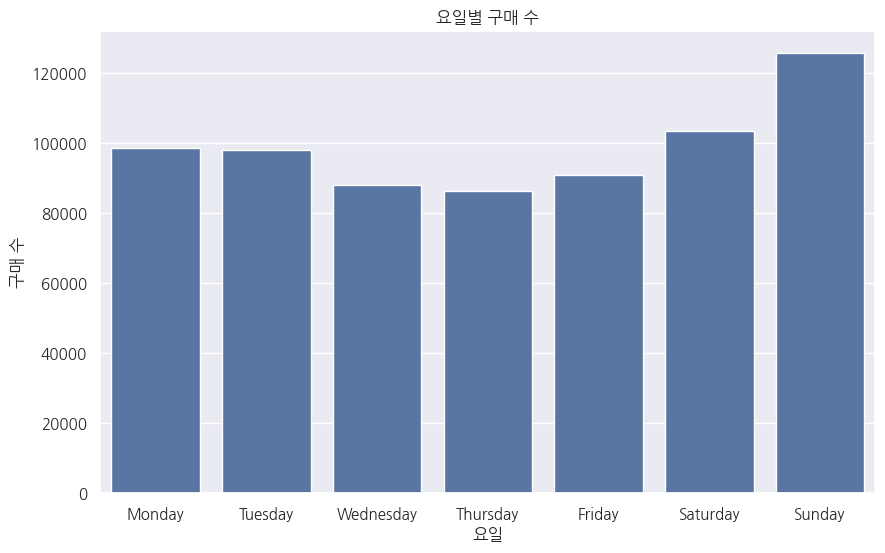

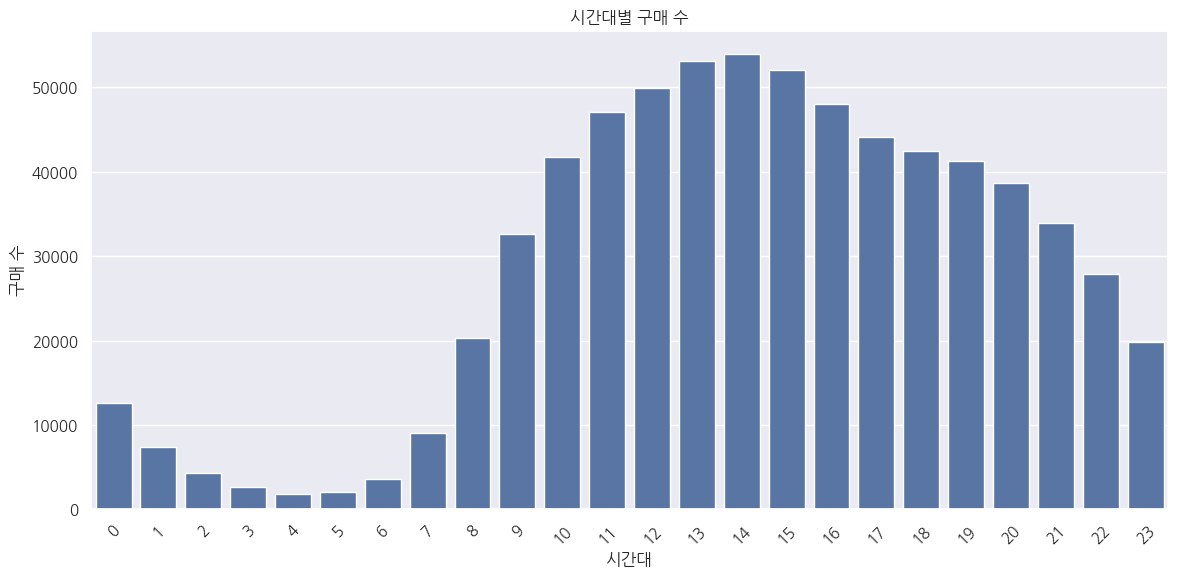

In [ ]:
# 요일별 구매 수 시각화
plt.figure(figsize=(10, 6))
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.barplot(x=weekday_purchase.index, y=weekday_purchase.values, order=weekday_order) # order를 지정하여 월~일 순서대로 정렬
plt.title('요일별 구매 수')
plt.xlabel('요일')
plt.ylabel('구매 수')
plt.show()

# 시간대별 구매 수 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x=hour_purchase.index, y=hour_purchase.values)
plt.title('시간대별 구매 수')
plt.xlabel('시간대')
plt.ylabel('구매 수')
plt.xticks(rotation=45) # 시간대 레이블이 겹치지 않도록 회전
plt.tight_layout() # 그래프 레이아웃 자동 조정
plt.show()

In [ ]:
# 층화 샘플링 750 데이터 불러오기
df_sampling = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datathon/주력_비주력상품 데이터/층화샘플링/top3_categories_750.csv')

/tmp/ipython-input-3911564163.py:2: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sampling = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datathon/주력_비주력상품 데이터/층화샘플링/top3_categories_750.csv')


In [ ]:
# 1회 구매 고객만 필터링
# 구매 이벤트만 필터링하여 user별 구매 횟수 계산
purchase_counts = df_sampling[df_sampling['event_type'] == 'purchase'].groupby('user_id').size()

# 한 번만 구매한 고객 리스트 추출
one_time_buyers = purchase_counts[purchase_counts == 1].index

# 전체 이벤트에서 구매 1회 고객만 필터링
one_time_df = df_sampling[df_sampling['user_id'].isin(one_time_buyers)]

In [ ]:
#5-1. 요일/시간대 분석 - one_time_df
# # event_date를 datetime으로 변환
# one_time_df['event_date'] = pd.to_datetime(one_time_df['event_date'])

# 구매 이벤트만 추출
purchase_one_time_df = one_time_df[one_time_df['event_type'] == 'purchase']

# 요일별 구매 수
weekday_purchase = purchase_one_time_df['weekday'].value_counts()

# 시간대별 구매 수
hour_purchase = purchase_one_time_df['event_hour'].value_counts().sort_index()

print("요일별 구매 수:\n", weekday_purchase)
print("시간대별 구매 수:\n", hour_purchase)

요일별 구매 수:
 weekday
Sunday       19494
Saturday     16823
Monday       16697
Tuesday      16150
Wednesday    15517
Friday       15448
Thursday     14947
Name: count, dtype: int64
시간대별 구매 수:
 event_hour
0     2534
1     1604
2     1017
3      674
4      424
5      428
6      634
7     1568
8     3526
9     5455
10    6908
11    7730
12    8234
13    8714
14    8814
15    8317
16    7683
17    7105
18    6829
19    6788
20    6225
21    5381
22    4740
23    3744
Name: count, dtype: int64


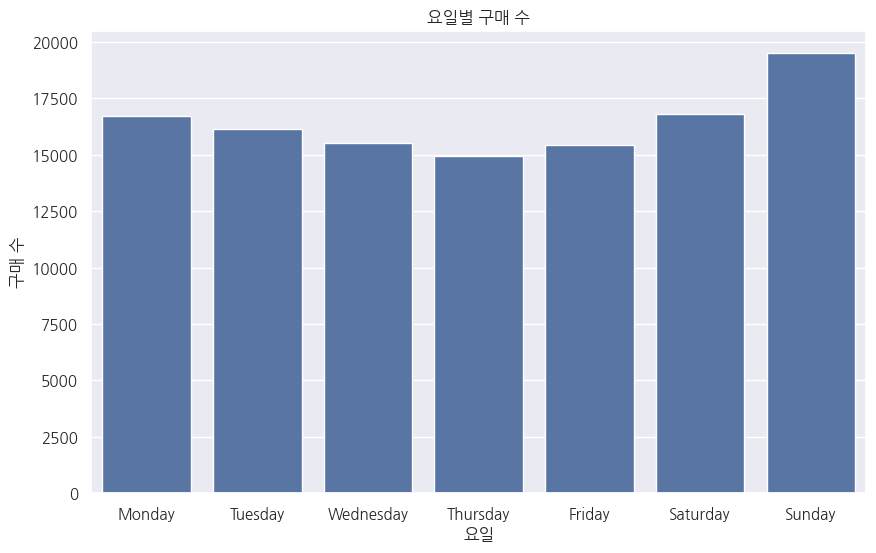

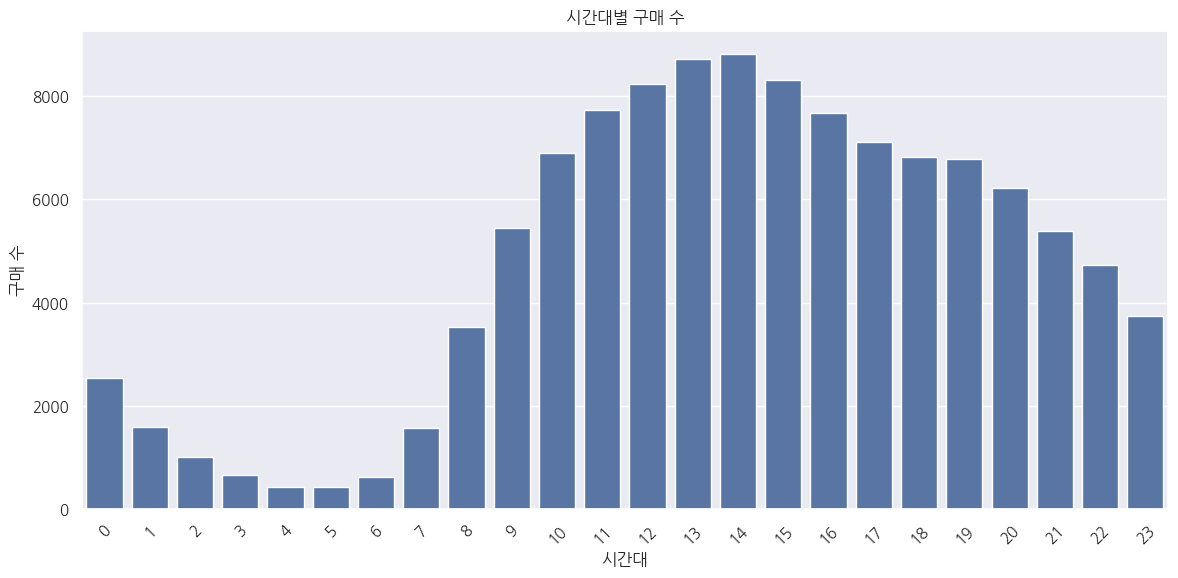

In [ ]:
# 요일별 구매 수 시각화 - one_time_df
plt.figure(figsize=(10, 6))
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.barplot(x=weekday_purchase.index, y=weekday_purchase.values, order=weekday_order) # order를 지정하여 월~일 순서대로 정렬
plt.title('요일별 구매 수')
plt.xlabel('요일')
plt.ylabel('구매 수')
plt.show()

# 시간대별 구매 수 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x=hour_purchase.index, y=hour_purchase.values)
plt.title('시간대별 구매 수')
plt.xlabel('시간대')
plt.ylabel('구매 수')
plt.xticks(rotation=45) # 시간대 레이블이 겹치지 않도록 회전
plt.tight_layout() # 그래프 레이아웃 자동 조정
plt.show()

In [ ]:
# 2회 이상 구매 고객 필터링
# 구매 이벤트만 필터링해서 user_id별 구매 횟수 계산
purchase_counts = df_sampling[df_sampling['event_type'] == 'purchase'].groupby('user_id').size()

# 2번 이상 구매한 고객 ID 추출
multi_buyers = purchase_counts[purchase_counts >= 2].index

multi_buyer_df = df_sampling[df_sampling['user_id'].isin(multi_buyers)]

In [ ]:
#5-2. 요일/시간대 분석 - multi_buyer_df
# # event_date를 datetime으로 변환
# multi_buyer_df['event_date'] = pd.to_datetime(multi_buyer_df['event_date'])

# 구매 이벤트만 추출
purchase_multi_buyer_df = multi_buyer_df[multi_buyer_df['event_type'] == 'purchase']

# 요일별 구매 수
weekday_purchase = purchase_multi_buyer_df['weekday'].value_counts()

# 시간대별 구매 수
hour_purchase = purchase_multi_buyer_df['event_hour'].value_counts().sort_index()

print("요일별 구매 수:\n", weekday_purchase)
print("시간대별 구매 수:\n", hour_purchase)

요일별 구매 수:
 weekday
Monday       7095
Sunday       6868
Tuesday      6576
Wednesday    6493
Saturday     6362
Friday       6304
Thursday     6134
Name: count, dtype: int64
시간대별 구매 수:
 event_hour
0     1419
1      964
2      574
3      410
4      270
5      241
6      323
7      697
8     1683
9     2418
10    2864
11    3123
12    3187
13    3416
14    3320
15    3235
16    2886
17    2444
18    2401
19    2259
20    2084
21    1931
22    1869
23    1814
Name: count, dtype: int64


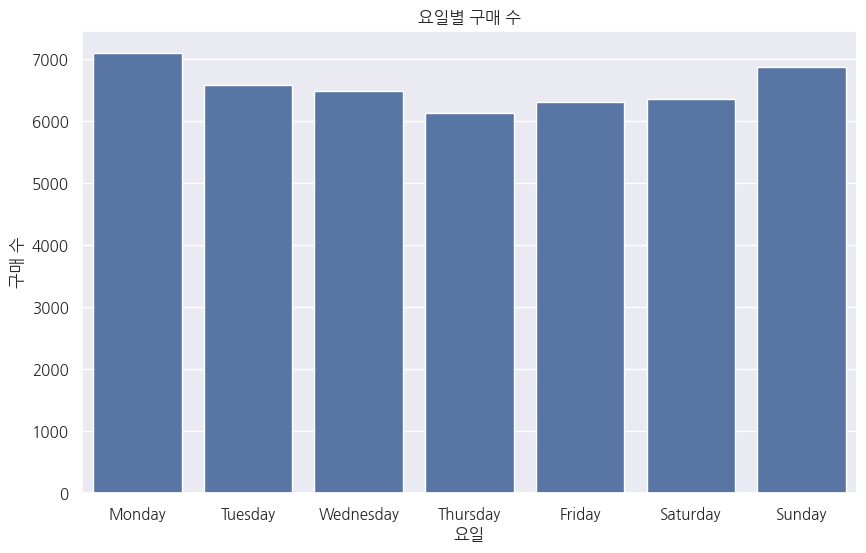

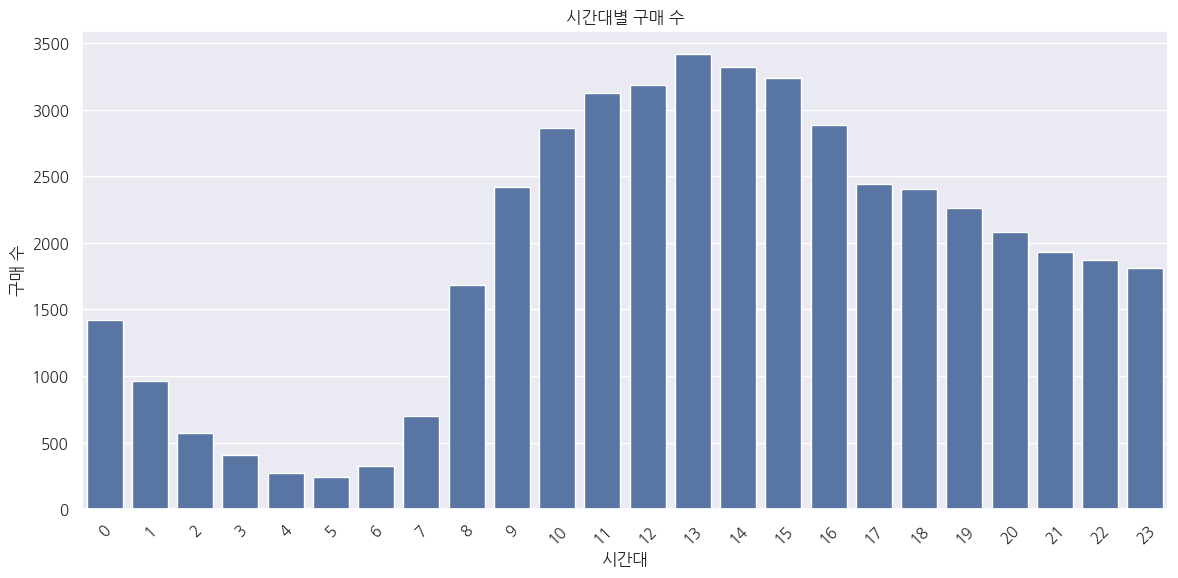

In [ ]:
# 요일별 구매 수 시각화
plt.figure(figsize=(10, 6))
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.barplot(x=weekday_purchase.index, y=weekday_purchase.values, order=weekday_order) # order를 지정하여 월~일 순서대로 정렬
plt.title('요일별 구매 수')
plt.xlabel('요일')
plt.ylabel('구매 수')
plt.show()

# 시간대별 구매 수 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x=hour_purchase.index, y=hour_purchase.values)
plt.title('시간대별 구매 수')
plt.xlabel('시간대')
plt.ylabel('구매 수')
plt.xticks(rotation=45) # 시간대 레이블이 겹치지 않도록 회전
plt.tight_layout() # 그래프 레이아웃 자동 조정
plt.show()

In [ ]:
# to. 지연님
########################### 코드는 여기까지 입니다!!

In [ ]:
# 1500만 행 층화 샘플링 데이터 불러오기
df_sample = pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/datathon/주력_비주력상품 데이터/층화샘플링/top3_categories.csv')

/tmp/ipython-input-2970812060.py:2: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sample = pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/datathon/주력_비주력상품 데이터/층화샘플링/top3_categories.csv')


In [ ]:
# 1회 구매 고객만 필터링
# 구매 이벤트만 필터링하여 user별 구매 횟수 계산
purchase_counts = df_sample[df_sample['event_type'] == 'purchase'].groupby('user_id').size()

# 한 번만 구매한 고객 리스트 추출
one_time_buyers = purchase_counts[purchase_counts == 1].index

# 전체 이벤트에서 구매 1회 고객만 필터링
one_time_df = df_sample[df_sample['user_id'].isin(one_time_buyers)]

In [ ]:
# 퍼널 분석 (view-cart-purchase 단계별 유저 수 및 전환율) -> one_time_df
# 사용자별 event_type 집계
funnel_counts = one_time_df.groupby('event_type')['user_id'].nunique().reindex(['view', 'cart', 'purchase'])

# 전환율 계산 (순차적 전환 기준)
view_to_cart = funnel_counts['cart'] / funnel_counts['view'] if funnel_counts['view'] else 0
cart_to_purchase = funnel_counts['purchase'] / funnel_counts['cart'] if funnel_counts['cart'] else 0
view_to_purchase = funnel_counts['purchase'] / funnel_counts['view'] if funnel_counts['view'] else 0

print(funnel_counts)
print(f"view_to_cart: {view_to_cart}")
print(f"cart_to_purchase: {cart_to_purchase}")
print(f"view_to_purchase: {view_to_purchase}")

event_type
view        152290
cart         75183
purchase    193314
Name: user_id, dtype: int64
view_to_cart: 0.49368310460306
cart_to_purchase: 2.5712461593711344
view_to_purchase: 1.269380786657036


In [ ]:
# 2회 이상 구매 고객 필터링
# 구매 이벤트만 필터링해서 user_id별 구매 횟수 계산
purchase_counts = df_sample[df_sample['event_type'] == 'purchase'].groupby('user_id').size()

# 2번 이상 구매한 고객 ID 추출
multi_buyers = purchase_counts[purchase_counts >= 2].index

multi_buyer_df = df_sample[df_sample['user_id'].isin(multi_buyers)]

In [ ]:
# 퍼널 분석 (view-cart-purchase 단계별 유저 수 및 전환율) -> multi_buyer_df
# 사용자별 event_type 집계
funnel_counts = multi_buyer_df.groupby('event_type')['user_id'].nunique().reindex(['view', 'cart', 'purchase'])

# 전환율 계산 (순차적 전환 기준)
view_to_cart = funnel_counts['cart'] / funnel_counts['view'] if funnel_counts['view'] else 0
cart_to_purchase = funnel_counts['purchase'] / funnel_counts['cart'] if funnel_counts['cart'] else 0
view_to_purchase = funnel_counts['purchase'] / funnel_counts['view'] if funnel_counts['view'] else 0

print(funnel_counts)
print(f"view_to_cart: {view_to_cart}")
print(f"cart_to_purchase: {cart_to_purchase}")
print(f"view_to_purchase: {view_to_purchase}")

event_type
view        41061
cart        32150
purchase    43382
Name: user_id, dtype: int64
view_to_cart: 0.7829814178904556
cart_to_purchase: 1.349362363919129
view_to_purchase: 1.0565256569494168


In [ ]:
#5-1. 요일/시간대 분석 - 1500 층화 샘플링(1회만)
# # event_date를 datetime으로 변환
# one_time_df['event_date'] = pd.to_datetime(one_time_df['event_date'])

# 구매 이벤트만 추출
purchase_one_time_df = one_time_df[one_time_df['event_type'] == 'purchase']

# 요일별 구매 수
weekday_purchase = purchase_one_time_df['weekday'].value_counts()

# 시간대별 구매 수
hour_purchase = purchase_one_time_df['event_hour'].value_counts().sort_index()

print("요일별 구매 수:\n", weekday_purchase)
print("시간대별 구매 수:\n", hour_purchase)

요일별 구매 수:
 weekday
Sunday       32958
Monday       28226
Saturday     28217
Tuesday      27165
Friday       25987
Wednesday    25977
Thursday     24784
Name: count, dtype: int64
시간대별 구매 수:
 event_hour
0      4071
1      2609
2      1574
3       997
4       677
5       633
6      1042
7      2604
8      5868
9      9203
10    11534
11    12884
12    13736
13    14679
14    14896
15    14082
16    13042
17    12107
18    11611
19    11319
20    10691
21     9278
22     8083
23     6094
Name: count, dtype: int64


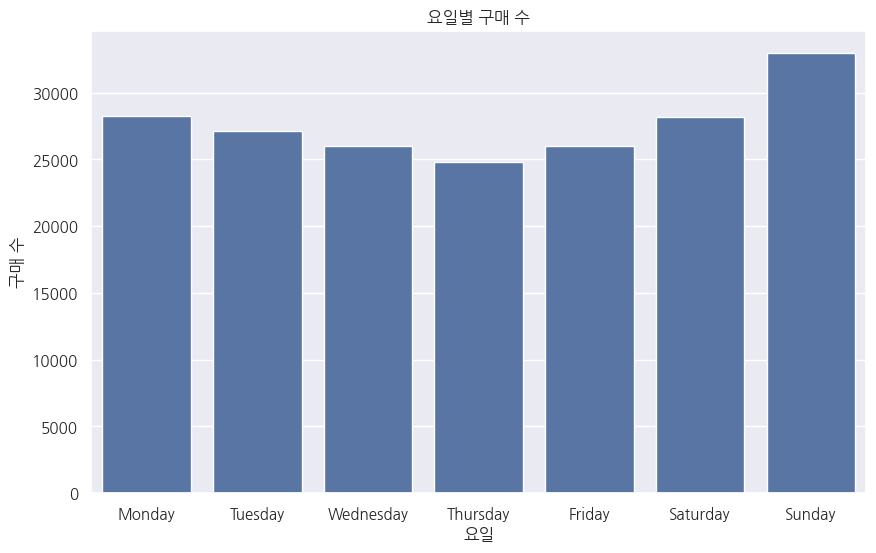

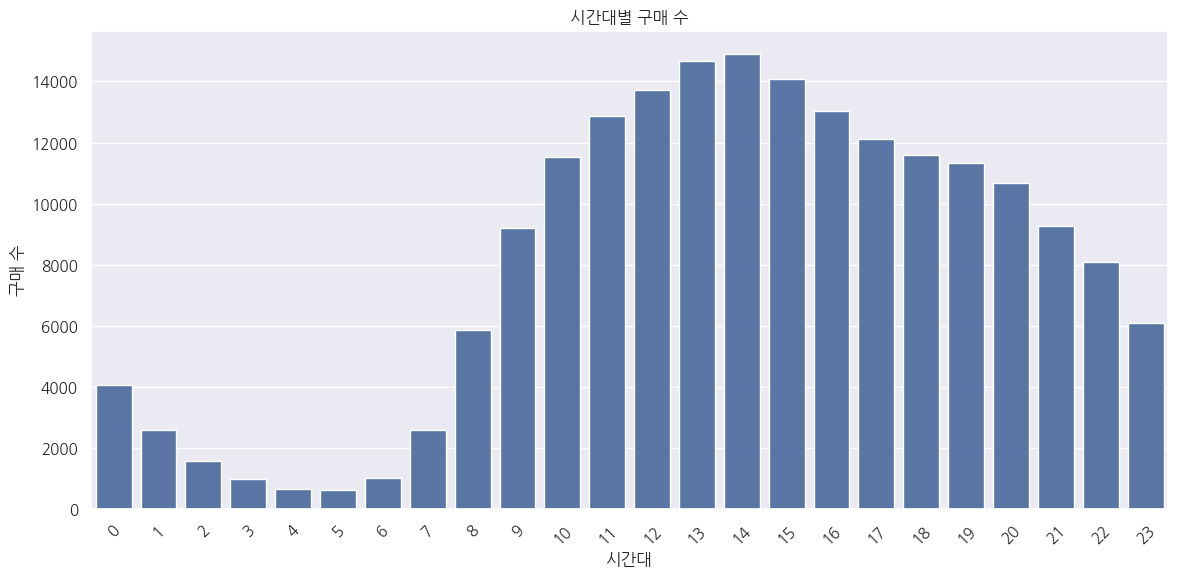

In [ ]:
# 요일별 구매 수 시각화
plt.figure(figsize=(10, 6))
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.barplot(x=weekday_purchase.index, y=weekday_purchase.values, order=weekday_order) # order를 지정하여 월~일 순서대로 정렬
plt.title('요일별 구매 수')
plt.xlabel('요일')
plt.ylabel('구매 수')
plt.show()

# 시간대별 구매 수 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x=hour_purchase.index, y=hour_purchase.values)
plt.title('시간대별 구매 수')
plt.xlabel('시간대')
plt.ylabel('구매 수')
plt.xticks(rotation=45) # 시간대 레이블이 겹치지 않도록 회전
plt.tight_layout() # 그래프 레이아웃 자동 조정
plt.show()

In [ ]:
#5-2. 요일/시간대 분석 - 1500 층화 샘플링(2회 이상)
# # event_date를 datetime으로 변환
# multi_buyer_df['event_date'] = pd.to_datetime(multi_buyer_df['event_date'])

# 구매 이벤트만 추출
purchase_multi_buyer_df = multi_buyer_df[multi_buyer_df['event_type'] == 'purchase']

# 요일별 구매 수
weekday_purchase = purchase_multi_buyer_df['weekday'].value_counts()

# 시간대별 구매 수
hour_purchase = purchase_multi_buyer_df['event_hour'].value_counts().sort_index()

print("요일별 구매 수:\n", weekday_purchase)
print("시간대별 구매 수:\n", hour_purchase)

요일별 구매 수:
 weekday
Monday       19568
Sunday       19377
Tuesday      18522
Wednesday    18214
Friday       17640
Saturday     17592
Thursday     17295
Name: count, dtype: int64
시간대별 구매 수:
 event_hour
0     3813
1     2512
2     1603
3     1052
4      711
5      645
6      898
7     1941
8     4534
9     6840
10    7960
11    8672
12    9016
13    9328
14    9357
15    8976
16    8217
17    7136
18    6839
19    6425
20    5977
21    5552
22    5296
23    4908
Name: count, dtype: int64


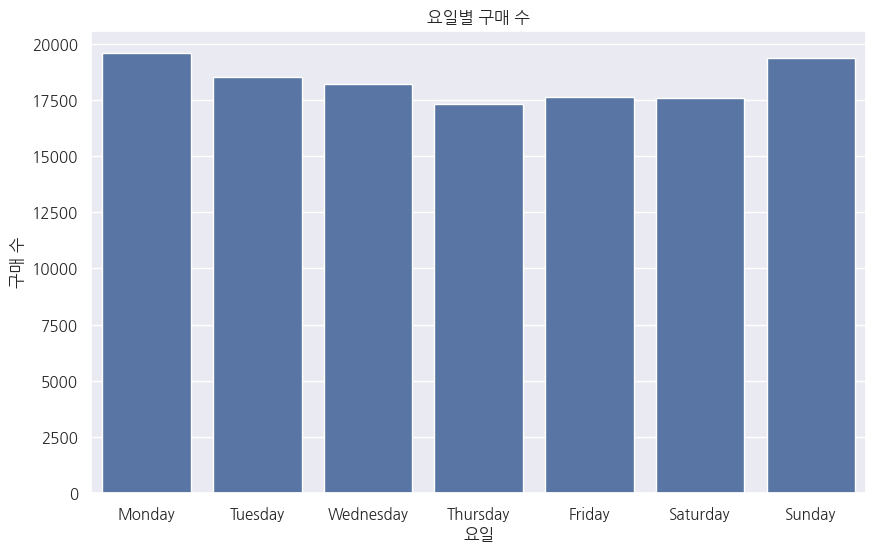

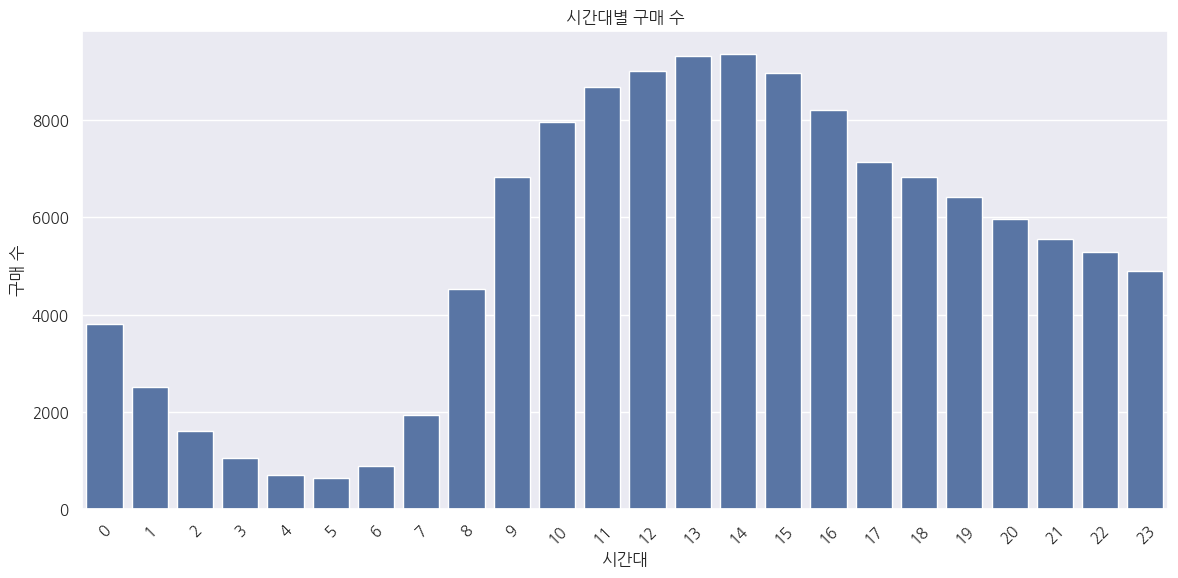

In [ ]:
# 요일별 구매 수 시각화
plt.figure(figsize=(10, 6))
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.barplot(x=weekday_purchase.index, y=weekday_purchase.values, order=weekday_order) # order를 지정하여 월~일 순서대로 정렬
plt.title('요일별 구매 수')
plt.xlabel('요일')
plt.ylabel('구매 수')
plt.show()

# 시간대별 구매 수 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x=hour_purchase.index, y=hour_purchase.values)
plt.title('시간대별 구매 수')
plt.xlabel('시간대')
plt.ylabel('구매 수')
plt.xticks(rotation=45) # 시간대 레이블이 겹치지 않도록 회전
plt.tight_layout() # 그래프 레이아웃 자동 조정
plt.show()

- 두 집단 모두 view → cart → purchase 경로가 주요 흐름이긴 하나, 다회 구매자는 더 길고 반복적인 행동 흐름이 나타남 (ex. view → cart → 다시 view 등)

| 항목               | 다회 구매자    | 1회 구매자  | 차이점                   |
| ---------------- | --------- | ------- | --------------------- |
| **평균 세션 수**      | **15.73** | 8.36    | 🔻 7.4개 세션 적음 (약 53%) |
| **평균 이벤트 수**     | **83.51** | 41.11   | 🔻 절반 수준              |
| **평균 탐색 카테고리 수** | **2.20**  | 1.86    | 🔻 약 15% 감소           |
| **평균 브랜드 수**     | **8.47**  | 5.74    | 🔻 약 32% 감소           |
| **평균 구매 간격(일)**  | **7.87일** | (해당 없음) | -                     |

!! 인사이트 도출: 재구매자와의 차이점

A. 탐색 깊이 부족
- 1회 구매자는 세션 수와 이벤트 수가 절반 이하로, 짧은 시간 안에 결정을 내리고 이탈한 경향이 큼

- 브랜드/카테고리 다양성도 낮아, 충성도나 대안 비교보다는 단발성 소비 성향

B. 반복 방문 부족
- 다회 구매자는 평균 15개 이상 세션을 가진 반면, 1회 구매자는 8개 -> 재방문을 유도할 수 있는 리마인드가 부족했을 가능성

C. 마케팅 타이밍 인식 부족
- 다회 구매자의 평균 재구매 간격은 약 8일 -> 이 타이밍에 맞춰 리마인드 캠페인을 했더라면 재구매로 이어졌을 수도

!! 전략 제안: 1회 구매자 리텐션 유도

| 전략                   | 구체적 방안                                         |
| -------------------- | ---------------------------------------------- |
| **① 리마인드 마케팅 강화**    | 첫 구매 후 **7\~8일 이내** 타겟팅 메시지 발송 (할인, 신상품 안내 등)  |
| **② 카테고리 확장 유도**     | 다른 인기 카테고리 **AI 추천** 또는 **“이 상품을 본 사람은\~”** 배너 |
| **③ 브랜드 다양성 자극**     | 동일 상품 내 **브랜드 비교 유도형 UI** 또는 “유사 브랜드 추천” 제공    |
| **④ 재구매 유인 혜택**      | 첫 구매 고객 한정 **다음 구매 쿠폰 제공**                     |
| **⑤ 행동 기반 세그먼트 타겟팅** | cart까지 갔다가 구매하지 않은 유저 → **푸시 알림 or 재입고 안내 메일** |

#2. 리텐션 패턴 탐색 (이탈 vs 재구매)

목적: 재구매한 고객과 이탈한 고객의 행동 차이 도출

리텐션 기준:
'드문' 고객의 평균 재구매 주기를 기준으로 cutoff 설정 → cutoff 이전에 2회 이상 구매한 고객은 리텐션, 아니라면 이탈

- 리텐션 그룹 vs 이탈 그룹의 행동 패턴 비교:

첫 방문 이후 구매까지 평균 시간

뷰/카트 횟수, 세션 수, 체류 시간, 주말/평일 이용 패턴

주력 vs 비주력 상품군 교차 사용 여부 (주력만 구매 vs 비주력 전환 여부)

#3. 행동 기반 재구매 유도 요인 분석
목적:
재구매 확률을 높이는 행동 패턴 도출

- 로지스틱 회귀 / 결정트리 기반 feature importance

예: (최근 세션 수, cart 이벤트 비율, 방문 시간대 등 → 재구매 여부)

- 행동 시퀀스 패턴 분석 (event sequence mining)

예: “view → cart → 다시 view” 같은 반복 행동이 많은 경우 재구매 확률 높음